# 状態空間モデル

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import requests
import io
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import minimize
from pykalman import KalmanFilter

In [2]:
%matplotlib inline

## パラメータの設定

In [3]:
np.set_printoptions(linewidth=1000, precision=2, floatmode='fixed', suppress=True)

result_dir_path = Path('result')
if not result_dir_path.exists():
    result_dir_path.mkdir(parents=True)

## 関数定義

In [4]:
def set_trend_matrixes(F, H, G, n_dim_trend):
    
    G[0, 0] = 1
    H[0, 0] = 1
    if n_dim_trend == 1: 
        F[0, 0] = 1
    elif n_dim_trend == 2:
        F[0, 0] = 2
        F[0, 1] = -1
        F[1, 0] = 1
    elif n_dim_trend == 3:
        F[0, 0] = 3
        F[0, 1] = -3
        F[0, 2] = 1
        F[1, 0] = 1
        F[2, 1] = 1
        
    index_state, index_obj = n_dim_trend, n_dim_trend
    
    return F, H, G, index_state, index_obj

In [5]:
def set_series_matrixes(F, H, G, n_dim_series, index_state, index_obj):
    
    if n_dim_series > 0:
        
        G[index_state, 1] = 1
        H[0, index_obj] = 1
        
        for i in range(n_dim_series-1): 
            F[index_state, index_state+i] = -1
            
        for i in range(n_dim_series-2): 
            F[index_state+i+1, index_state+i] = 1
            
        index_state = index_state + n_dim_series -1
        index_obj = index_obj + n_dim_series -1

    return F, H, G, index_state, index_obj

In [6]:
def set_ar_matrixes(F, H, G, n_dim_ar, index_state, index_obj):
        
    if n_dim_ar > 0:
        
        G[index_state, 2] = 1
        H[0, index_obj] = 1
        
        for i in range(n_dim_ar): 
            F[index_state, index_state+i] = 0
            
        for i in range(n_dim_ar-1): 
            F[index_state+i+1, index_state+i] = 1
            
    return F, H, G, index_state, index_obj

In [7]:
def set_state_space_model_matrixes(
    n_dim_trend, n_dim_obs=1, n_dim_series=0, n_dim_ar=0, Q_sigma2=10
):
    
    if n_dim_series > 0 or n_dim_ar > 0:
        n_dim_state = n_dim_trend + n_dim_series + n_dim_ar - 1
    else:
        n_dim_state = n_dim_trend
    n_dim_Q = (n_dim_trend != 0) + (n_dim_series != 0) + (n_dim_ar != 0)
    
    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma2
    
    F, H, G, index_state, index_obj = set_trend_matrixes(
        F=F, H=H, G=G,
        n_dim_trend=n_dim_trend
    )

    F, H, G, index_state, index_obj = set_series_matrixes(
        F=F, H=H, G=G, 
        n_dim_series=n_dim_series,
        index_state=index_state,
        index_obj=index_obj
    )
    
    F, H, G, index_state, index_obj = set_ar_matrixes(
        F=F, H=H, G=G, 
        n_dim_ar=n_dim_ar,
        index_state=index_state,
        index_obj=index_obj
    )
            
    Q = G.dot(Q).dot(G.T)
    
    return F, H, Q, n_dim_state

In [28]:
def plot_state_space_model_pred(
    kf, y, n_train, credible_interval=True, img_file_path=None
):
    
    train_data, test_data = y[:n_train], y[n_train:]
    
    state_means, state_covs = kf.smooth(train_data)
    ovsevation_means_predicted = np.dot(state_means, kf.observation_matrices.T)
    ovsevation_covs_predicted = kf.observation_matrices.dot(
        np.abs(state_covs)
    ).transpose(1, 0, 2).dot(kf.observation_matrices.T)

    lowers, uppers = scipy.stats.norm.interval(
        0.95, 
        ovsevation_means_predicted.flatten(), 
        scale=np.sqrt(ovsevation_covs_predicted.flatten())
    )

    current_state = state_means[-1]
    current_cov = state_covs[-1]

    pred_means = np.array([])
    tmp_lowers = []
    tmp_uppers = []
    for i in range(len(test_data)):

        current_state, current_cov = kf.filter_update(
            current_state, current_cov, observation=None
        )
        pred_mean = current_state.dot(kf.observation_matrices.T)
        pred_cov = kf.observation_matrices.dot(
            np.abs(current_cov)
        ).dot(kf.observation_matrices.T)

        pred_means = np.r_[pred_means, pred_mean] 

        lower, upper = scipy.stats.norm.interval(
            0.95, pred_mean, scale=np.sqrt(pred_cov)
        )
        tmp_lowers.append(lower)
        tmp_uppers.append(upper)

    lowers = np.hstack([lowers, np.array(tmp_lowers).flatten()])
    uppers = np.hstack([uppers, np.array(tmp_uppers).flatten()])

    plt.figure(figsize=(8, 6))
    plt.plot(y, label="observation")
    plt.plot(
        np.hstack([
            ovsevation_means_predicted.flatten(), 
            pred_means.flatten()
        ]), 
        '--', label="forecast"
    )
    if credible_interval:
        plt.fill_between(range(len(y)), uppers, lowers, alpha=0.5, label="credible interval")
    plt.legend()
    plt.tight_layout()

    if img_file_path:
        plt.savefig(img_file_path)

In [29]:
def plot_state_space_model_process(kf, y, n_train, n_dim_trend, n_dim_series=0, n_dim_ar=0, img_file_path=None):
    
    train_data, test_data = y[:n_train], y[n_train:]

    state_means, state_covs = kf.smooth(train_data)
    
    index_start = 0
    index_end = n_dim_trend
    smoothed_means_trend = np.dot(
        state_means[:, index_start:index_end],
        kf.observation_matrices[:, index_start:index_end].T
    )
    index_start = index_end
    
    if n_dim_series > 0:
        index_end = index_start + n_dim_series - 1
        smoothed_means_series = np.dot(
            state_means[:, index_start:index_end],
            kf.observation_matrices[:, index_start:index_end].T
        )
        index_start = index_end
        
    if n_dim_ar > 0:
        index_end = index_start + n_dim_ar
        smoothed_means_ar = np.dot(
            state_means[:, index_start:index_end],
            kf.observation_matrices[:, index_start:index_end].T
        )

        
    pred_means_trend = []
    if n_dim_series > 0:
        pred_means_series = []
    if n_dim_ar > 0:
        pred_means_ar = []

    current_state = state_means[-1]
    current_cov = state_covs[-1]
    for i in range(len(test_data)):
        current_state, current_cov = kf.filter_update(
            current_state, 
            current_cov,
            observation=None
        )
        
        index_start = 0
        index_end = n_dim_trend
        pred_means_trend.append(
            kf.observation_matrices[:, index_start:index_end].dot(current_state[index_start:index_end])
        )
        index_start = index_end
        
        if n_dim_series > 0:
            index_end = index_start + n_dim_series - 1
            pred_means_series.append(
                kf.observation_matrices[:, index_start:index_end].dot(current_state[index_start:index_end])
            )
            index_start = index_end
            
        if n_dim_ar > 0:
            index_end = index_start + n_dim_ar
            pred_means_ar.append(
                kf.observation_matrices[:, index_start:index_end].dot(current_state[index_start:index_end])
            )
            index_start = index_end
            

    plt.figure(figsize=(8, 6))
    plt.plot(y, label='observation')
    plt.plot(np.hstack([smoothed_means_trend.flatten(), np.array(pred_means_trend).flatten()]), '--', label='trend')
    if n_dim_series > 0:
        plt.plot(np.hstack([smoothed_means_series.flatten(), np.array(pred_means_series).flatten()]), ':', label='series')
    if n_dim_ar > 0:
        plt.plot(np.hstack([smoothed_means_ar.flatten(), np.array(pred_means_ar).flatten()]), '+-', label='ar')
    plt.legend()
    plt.tight_layout()
    
    if img_file_path:
        plt.savefig(img_file_path)

## データの取得

In [10]:
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
passengers = pd.read_csv(io.StringIO(stream.decode('utf-8')))

In [11]:
passengers.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<AxesSubplot:>

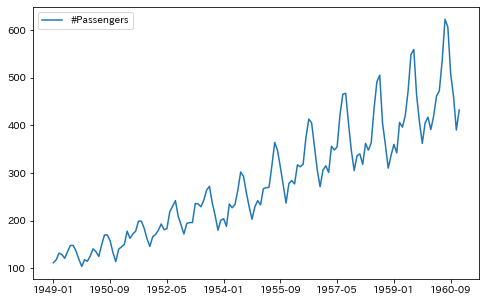

In [12]:
passengers.plot(
    x='Month',
    y='#Passengers', 
    figsize=(8, 5),
    xlabel=''
)

## データの加工

In [18]:
y = pd.Series(
    passengers['#Passengers'].values, 
    index=pd.to_datetime(passengers['Month'], infer_datetime_format=True)
)
y = y.astype(float)

In [19]:
n_train = 120
train_data, test_data = y.values[:n_train], y.values[n_train:]

##  トレンド推定モデル

### パラメータの設定

In [20]:
n_dim_obs = 1                  # 観測値の次元数
n_dim_trend = 2                # トレンドの次元数（状態の次元数）
n_dim_state = n_dim_trend

F = np.array([
    [2, -1],
    [1, 0]
], dtype=float)

G = np.array([
    [1],
    [0]
], dtype=float)

H = np.array([
    [1, 0]
], dtype=float)

Q = np.eye(1) * 10
Q = G.dot(Q).dot(G.T)

state_mean = np.zeros(n_dim_state)              # 状態の平均値ベクトルの初期値
state_cov = np.ones((n_dim_state, n_dim_state)) # 状態の分散共分散行列の初期値

### トレンド推定モデルの構築

In [21]:
kf = KalmanFilter(
    n_dim_obs=n_dim_obs,
    n_dim_state=n_dim_state,
    initial_state_mean=state_mean,
    initial_state_covariance=state_cov,
    transition_matrices=F,
    transition_covariance=Q,
    observation_matrices=H,
    observation_covariance=1.0,
)

### 平滑化

In [22]:
state_means, state_covs = kf.smooth(train_data)

In [23]:
print('状態の平均値 : \n{} \n\n 状態の共分散 : \n{}'.format(
    state_means[:4],
    state_covs[:4]
))

状態の平均値 : 
[[ 59.91  59.91]
 [109.58  59.91]
 [130.65 109.58]
 [129.08 130.65]] 

 状態の共分散 : 
[[[0.47 0.47]
  [0.47 0.47]]

 [[0.68 0.09]
  [0.09 0.47]]

 [[0.71 0.16]
  [0.16 0.68]]

 [[0.71 0.17]
  [0.17 0.71]]]


In [31]:
ovsevation_means_predicted = np.dot(state_means, kf.observation_matrices.T)

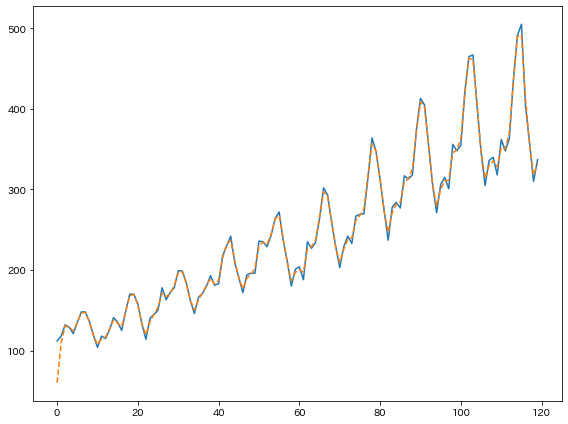

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(train_data, label="observation")
plt.plot(ovsevation_means_predicted, '--', label="forecast")
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('passenger_trend_smooth.png'))

### 予測

In [36]:
train_data, test_data = y[:n_train], y[n_train:]
    
state_means, state_covs = kf.smooth(train_data)
ovsevation_means_predicted = np.dot(state_means, kf.observation_matrices.T)

current_state = state_means[-1]
current_cov = state_covs[-1]

pred_means = np.array([])
for i in range(len(test_data)):

    current_state, current_cov = kf.filter_update(
        current_state, current_cov, observation=None
    )
    pred_mean = kf.observation_matrices.dot(current_state)
    pred_means = np.r_[pred_means, pred_mean]

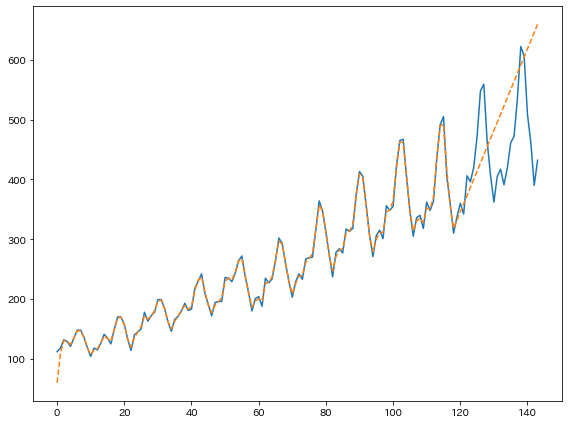

In [38]:
plt.figure(figsize=(8, 6))
plt.plot(y.values, label="observation")
plt.plot(
    np.hstack([
        ovsevation_means_predicted.flatten(), 
        np.array(pred_means).flatten()
    ]), 
    '--', label="forecast"
)
plt.tight_layout()
plt.savefig(result_dir_path.joinpath('passenger_trend_predict.png'))

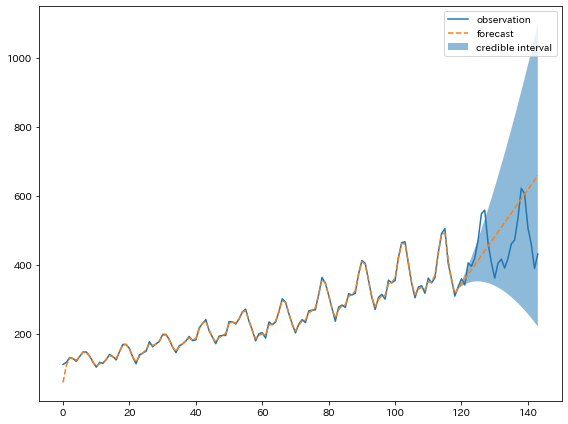

In [34]:
plot_state_space_model_pred(
    kf=kf, y=y.values, n_train=n_train, credible_interval=True,
    img_file_path=result_dir_path.joinpath('passenger_trend_predict.png')
)

## 季節調整モデル

In [19]:
n_dim_obs = 1
n_dim_trend = 2
n_dim_series = 12
Q_sigma2 = 10

In [20]:
n_dim_Q = (n_dim_trend != 0) + (n_dim_series != 0)
n_dim_state = n_dim_trend + n_dim_series - 1

F = np.zeros((n_dim_state, n_dim_state))
G = np.zeros((n_dim_state, n_dim_Q))
Q = np.eye(n_dim_Q) * Q_sigma2
H = np.zeros((n_dim_obs, n_dim_state))

F[0, 0] = 2
F[0, 1] = -1
F[1, 0] = 1

G[0, 0] = 1
H[0, 0] = 1

index_state = n_dim_trend
index_obj = n_dim_trend

if n_dim_series > 0:
    G[index_state, 1] = 1
    H[0, index_obj] = 1
    
    for i in range(n_dim_series-1): 
        F[index_state, index_state+i] = -1
        
    for i in range(n_dim_series-2): 
        F[index_state+i+1, index_state+i] = 1

Q = G.dot(Q).dot(G.T)

In [21]:
kf = KalmanFilter(
    n_dim_obs=n_dim_obs,
    n_dim_state=n_dim_state,
    initial_state_mean=np.zeros(n_dim_state),
    initial_state_covariance=np.ones((n_dim_state, n_dim_state)),
    transition_matrices=F,
    transition_covariance=Q,
    observation_matrices=H,
    observation_covariance=1.0
)

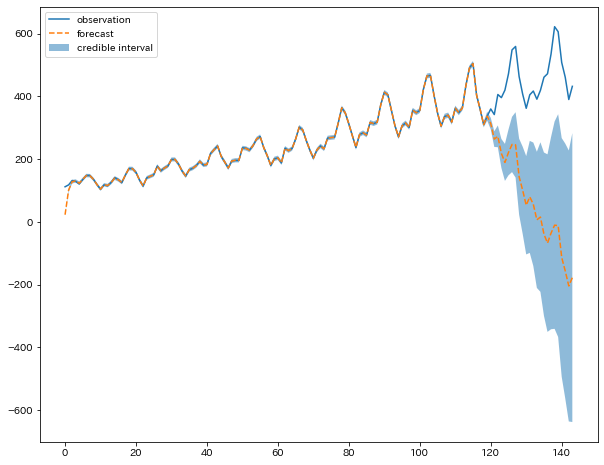

In [22]:
plot_state_space_model_pred(
    kf=kf, y=y.values, n_train=n_train, credible_interval=True,
    img_file_path=result_dir_path.joinpath('passenger_series_predict.png')
)

## EMアルゴリズムを用いたハイパーパラメータ最適化

In [23]:
n_dim_obs = 1
n_dim_trend = 2
n_dim_series = 12
Q_sigma2 = 10

In [24]:
n_dim_Q = (n_dim_trend != 0) + (n_dim_series != 0)
n_dim_state = n_dim_trend + n_dim_series - 1

F = np.zeros((n_dim_state, n_dim_state))
G = np.zeros((n_dim_state, n_dim_Q))
Q = np.eye(n_dim_Q) * Q_sigma2
H = np.zeros((n_dim_obs, n_dim_state))

F[0, 0] = 2
F[0, 1] = -1
F[1, 0] = 1

G[0, 0] = 1
H[0, 0] = 1

index_state = n_dim_trend
index_obj= n_dim_trend

if n_dim_series > 0:
    G[index_state, 1] = 1
    H[0, index_obj] = 1
    
    for i in range(n_dim_series-1): 
        F[index_state, index_state+i] = -1
        
    for i in range(n_dim_series-2): 
        F[index_state+i+1, index_state+i] = 1

Q = G.dot(Q).dot(G.T)

In [25]:
kf = KalmanFilter(
    n_dim_obs=n_dim_obs,
    n_dim_state=n_dim_state,
    initial_state_mean=np.zeros(n_dim_state),
    initial_state_covariance=np.ones((n_dim_state, n_dim_state)),
    transition_matrices=F,
    transition_covariance=Q,
    observation_matrices=H,
    observation_covariance=1.0
)

In [26]:
emed_kf = kf.em(train_data, n_iter=10, em_vars='all')

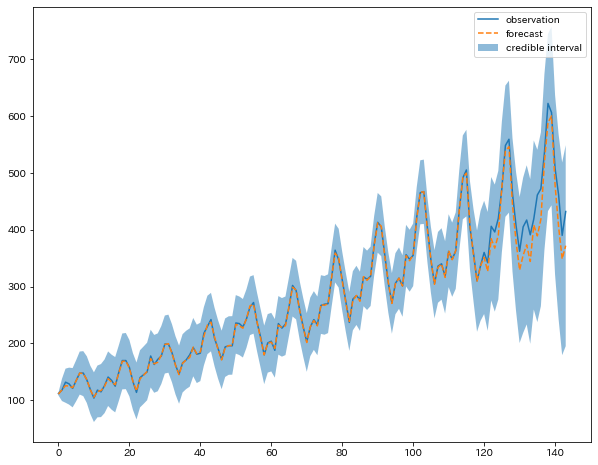

In [27]:
plot_state_space_model_pred(
    kf=emed_kf, y=y.values, n_train=n_train, credible_interval=True,
    img_file_path=result_dir_path.joinpath('passenger_series_em_predict.png')
)

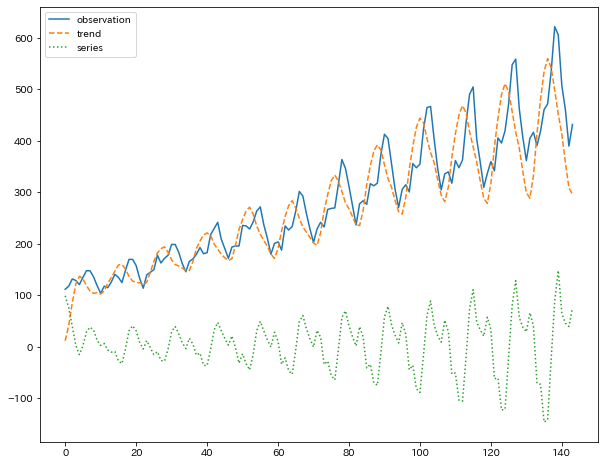

In [28]:
plot_state_space_model_process(
    kf=kf, y=y.values, n_train=n_train, 
    n_dim_trend=n_dim_trend,
    n_dim_series=n_dim_series,
    n_dim_ar=0,
    img_file_path=result_dir_path.joinpath('passenger_series_em_process.png')
)

## AR付き状態空間モデル

In [29]:
n_dim_obs = 1
n_dim_trend = 2
n_dim_series = 12
n_dim_ar = 2

F, H, Q, n_dim_state = set_state_space_model_matrixes(
    n_dim_trend=n_dim_trend, 
    n_dim_obs=n_dim_obs, 
    n_dim_series=n_dim_series, 
    n_dim_ar=n_dim_ar
)

In [30]:
kf = KalmanFilter(
    n_dim_obs=n_dim_obs,
    n_dim_state=n_dim_state,
    initial_state_mean=np.zeros(n_dim_state),
    initial_state_covariance=np.ones((n_dim_state, n_dim_state)),
    transition_matrices=F,
    observation_matrices=H,
    observation_covariance=1.0,
    transition_covariance=Q
)

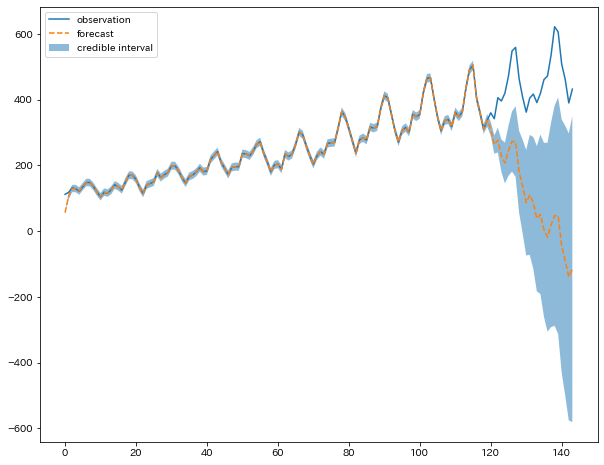

In [31]:
plot_state_space_model_pred(
    kf=kf, y=y.values, n_train=n_train,
    img_file_path=result_dir_path.joinpath('passenger_ar_predict.png')
)

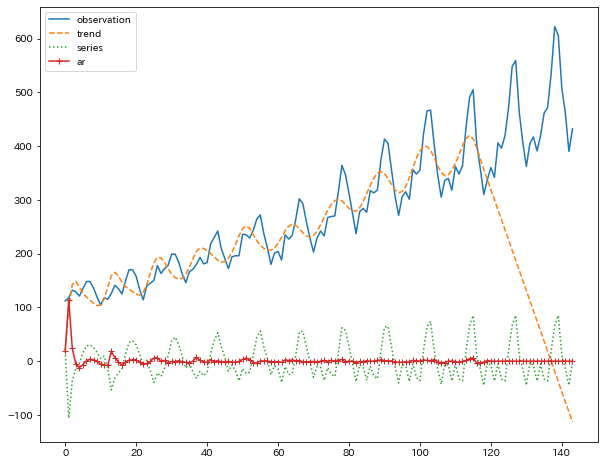

In [32]:
plot_state_space_model_process(
    kf=kf, y=y.values, n_train=n_train, 
    n_dim_trend=n_dim_trend,
    n_dim_series=n_dim_series,
    n_dim_ar=n_dim_ar,
    img_file_path=result_dir_path.joinpath('passenger_ar_process.png')
)

### パラメータの最適化

In [34]:
def minimize_likelihood_ar(
    target, kf, train_data, index_ar_target, index_series_end
):
    
    kf.transition_matrices[index_series_end, index_series_end+index_ar_target] = target
    kf.smooth(train_data)
    
    return -kf.loglikelihood(train_data)


def minimize_likelihood_q(target, kf, train_data, index_target):
    
    kf.transition_covariance[index_target, index_target] = target
    kf.smooth(train_data)
    
    return -kf.loglikelihood(train_data)


def ar_coef(vector, n_dim_ar):
    
    ar_hat = np.zeros(n_dim_ar)
    
    if n_dim_ar == 1:
        ar_hat = vector
    else:
        am = np.zeros(n_dim_ar)
        
        for i in range(n_dim_ar):
            ar_hat[i] = vector[i]
            am[i] = vector[i]
            if i > 0:
                for j in range(i-1):
                    ar_hat[j] = am[j] - vector[i] * am[i-j]
                    
                if i < n_dim_ar-1:
                    for j in range(i-1):
                        am[j] = ar_hat[j]
                        
    return ar_hat

In [35]:
index_series_end = n_dim_trend + n_dim_series - 1

n_iter = 5
n_q = 2
bounds_ar = ((-0.95, 0.95), )
bounds_q = ((1e-4, 1e3), ) * (n_q) + ((1e-4, 5e1), )

kf_copy = copy.deepcopy(kf)

for index_ar_target in tqdm(range(n_dim_ar)):
    index_ar_end = index_series_end + index_ar_target
    
    for loop in range(n_iter):
        
        if index_ar_target > 0:
            ar_args = kf_copy.transition_matrices[index_series_end, index_series_end:index_ar_end]
            ar_cov = [
                kf_copy.transition_covariance[index_series_end+i, index_series_end+i] for i in range(index_ar_target)
            ]
            
        if loop == 0:
            kf_copy = copy.deepcopy(kf)
            
        if index_ar_target > 0:
            kf_copy.transition_matrices[index_series_end, index_series_end:index_ar_end] = ar_args
            for i in range(index_ar_target):
                kf_copy.transition_covariance[index_series_end+i, index_series_end+i] = ar_cov[i]

                
        minimize(
            minimize_likelihood_ar, 
            (0.,), 
            args=(kf_copy, train_data, index_ar_target, index_series_end), 
            method='SLSQP', 
            bounds=bounds_ar
        )

        cov_indexes = [index_series_end, n_dim_trend, 0]
        for i, index_target in enumerate(cov_indexes):
            
            minimize(
                minimize_likelihood_q, 
                (0., ), 
                args=(kf_copy, train_data, index_target), 
                method='SLSQP', 
                bounds=(bounds_q[len(cov_indexes)-i-1], )
            )

        
        if index_ar_target == 0:
            kf_copy.transition_matrices[index_series_end, index_series_end] = ar_coef(
                kf_copy.transition_matrices[index_series_end, index_series_end], 1
            )
        else:
            kf_copy.transition_matrices[index_series_end, index_series_end:index_ar_end+1] = \
                ar_coef(
                    kf_copy.transition_matrices[index_series_end, index_series_end:index_ar_end+1],
                    index_ar_target+1
                )

100%|██████████| 2/2 [02:23<00:00, 71.60s/it]


In [36]:
opt_kf = copy.deepcopy(kf_copy)

ARの遷移行列

In [37]:
opt_kf.transition_matrices[index_series_end: , index_series_end:]

array([[0.95, 0.06],
       [1.00, 0.00]])

共分散行列の遷移行列

In [38]:
np.diag(opt_kf.transition_covariance)

array([   0.00,    0.00, 1000.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,    0.00,   50.00,    0.00])

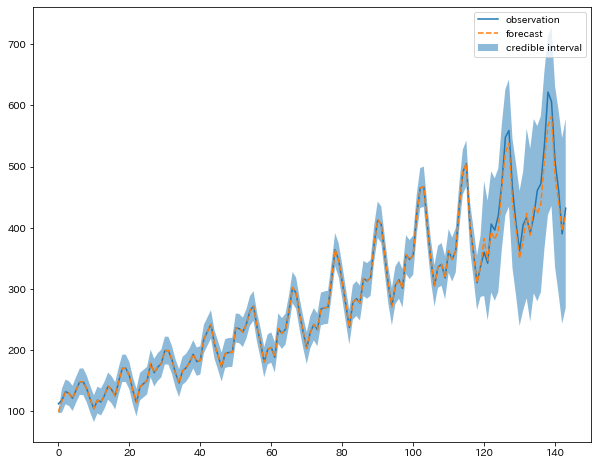

In [39]:
plot_state_space_model_pred(
    kf=opt_kf, y=y.values, n_train=n_train,
    img_file_path=result_dir_path.joinpath('passenger_ar_opt_predict.png')
)

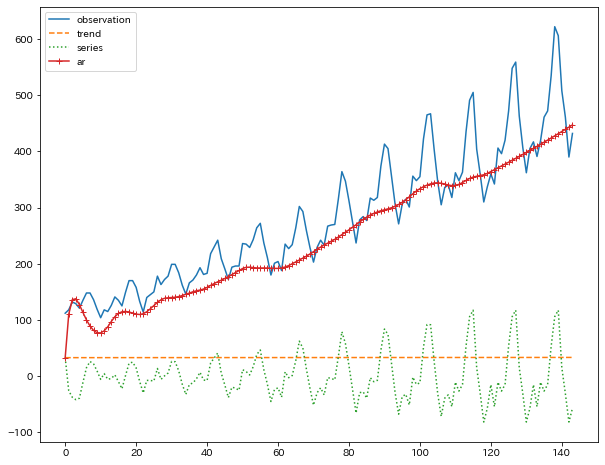

In [40]:
plot_state_space_model_process(
    kf=opt_kf, y=y.values, n_train=n_train, 
    n_dim_trend=n_dim_trend,
    n_dim_series=n_dim_series,
    n_dim_ar=n_dim_ar,
    img_file_path=result_dir_path.joinpath('passenger_ar_opt_process.png')
)